In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
name_df = pd.read_csv("https://datasets.imdbws.com/name.basics.tsv.gz", sep="\t")
name_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0031983,tt0050419,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0038355,tt0037382,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050976,tt0050986"


In [6]:
akas_df = pd.read_csv("https://datasets.imdbws.com/title.akas.tsv.gz", sep="\t", dtype={"titleId": "string", "ordering": str, "title ": "string", "region ": "string", 
"language ": "string", "types ": str, "attributes ": str, "isOriginalTitle": str})
akas_df

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0
...,...,...,...,...,...,...,...,...
29532538,tt9916852,5,Episódio #3.20,PT,pt,\N,\N,0
29532539,tt9916852,6,Episodio #3.20,IT,it,\N,\N,0
29532540,tt9916852,7,एपिसोड #3.20,IN,hi,\N,\N,0
29532541,tt9916856,1,The Wind,DE,\N,imdbDisplay,\N,0


In [4]:
basics_df = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", sep="\t", low_memory=False)
basics_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
8321897,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
8321898,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
8321899,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
8321900,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [118]:
crew_df = pd.read_csv("https://datasets.imdbws.com/title.crew.tsv.gz", sep="\t", low_memory=False)
crew_df

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
8370962,tt9916848,"nm5519454,nm5519375","nm6182221,nm1628284,nm2921377"
8370963,tt9916850,"nm5519454,nm5519375","nm6182221,nm1628284,nm2921377"
8370964,tt9916852,"nm5519454,nm5519375","nm6182221,nm1628284,nm2921377"
8370965,tt9916856,nm10538645,nm6951431


In [126]:
episode_df = pd.read_csv("https://datasets.imdbws.com/title.episode.tsv.gz", sep="\t", low_memory=False)
episode_df


,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0020666,tt15180956,1,2
1,tt0020829,tt15180956,1,1
2,tt0021166,tt15180956,1,3
3,tt0021612,tt15180956,2,2
4,tt0021655,tt15180956,2,5
...,...,...,...,...
6152197,tt9916846,tt1289683,3,18
6152198,tt9916848,tt1289683,3,17
6152199,tt9916850,tt1289683,3,19
6152200,tt9916852,tt1289683,3,20


In [73]:
principals_df = pd.read_csv("https://datasets.imdbws.com/title.principals.tsv.gz", sep="\t")
principals_df

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
47219890,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]"
47219891,tt9916880,5,nm0996406,director,principal director,\N
47219892,tt9916880,6,nm1482639,writer,\N,\N
47219893,tt9916880,7,nm2586970,writer,books,\N


In [117]:
ratings_df = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep="\t", low_memory=False)
ratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,1826
1,tt0000002,6.0,234
2,tt0000003,6.5,1583
3,tt0000004,6.1,152
4,tt0000005,6.2,2405
...,...,...,...
1195680,tt9916682,5.6,5
1195681,tt9916690,6.6,5
1195682,tt9916720,5.3,141
1195683,tt9916766,7.1,17


In [4]:
#Code to keep only "short", "movie" and "tvMovie"
basics_df2 = basics_df[(basics_df['titleType'] == 'movie') | (basics_df['titleType'] == 'tvMovie')]

#code to remove all lines with a startYear older than 1960
basics_df3 = basics_df2[basics_df2['startYear'] > str(1960)]

#code to remove all lines with a missing startYear
basics_df4 = basics_df3[basics_df3['startYear'] != '\\N']

#code to remove all lines with a missing genres
basics_df5 = basics_df4[basics_df4['genres'] != '\\N']
basics_df5

NameError: name 'basics_df' is not defined

In [183]:
basics_df6 = basics_df5.set_index('tconst')
ratings_df2 = ratings_df.set_index('tconst')
principals_df2 = principals_df.set_index('tconst')

In [189]:
crew_df2 = crew_df.set_index('tconst')

In [199]:
name_df2 = name_df.set_index('nconst')
name_df2

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0072308,tt0050419"
nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0071877,tt0038355,tt0037382"
nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0054452,tt0049189"
nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0072562,tt0078723,tt0080455"
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
...,...,...,...,...,...
nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt2455546"
nm9993716,Essias Loberg,\N,\N,NaN,\N
nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744


In [195]:
#akas_df2 = akas_df[(akas_df['region'] == 'FR') & (akas_df['title'] == 'Star Wars : Épisode VII - Le Réveil de la Force')]
#akas_df2 = akas_df[akas_df['region'] == 'FR']
#akas_df2 = akas_df[(akas_df['title'] == 'Mr. & Mrs. Smith') & (akas_df['region'] == 'FR')]
#akas_df2 = akas_df[akas_df['titleId'] == 'tt0000001']
#akas_df2 = akas_df[akas_df['title'] == 'Mr. & Mrs. Smith']

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
47337681,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]"
47337682,tt9916880,5,nm0996406,director,principal director,\N
47337683,tt9916880,6,nm1482639,writer,\N,\N
47337684,tt9916880,7,nm2586970,writer,books,\N


,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama
tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102,"Drama,Mystery,Romance"
tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical"
tt0021617,movie,Arizona Territory,Arizona Territory,0,1950,\N,56,"Action,Adventure,Western"
tt0022064,movie,Lebbra bianca,Lebbra bianca,0,1951,\N,100,Drama
...,...,...,...,...,...,...,...,...
tt9916362,movie,Coven,Akelarre,0,2020,\N,92,"Drama,History"
tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123,Drama
tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary


In [185]:
basics_df7 = pd.merge(basics_df6, ratings_df2, how='inner', left_index=True, right_index=True)

In [186]:
basics_df7

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,6.9,29
tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102,"Drama,Mystery,Romance",6.0,25
tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",5.6,19
tt0021617,movie,Arizona Territory,Arizona Territory,0,1950,\N,56,"Action,Adventure,Western",6.0,42
tt0022064,movie,Lebbra bianca,Lebbra bianca,0,1951,\N,100,Drama,5.3,53
...,...,...,...,...,...,...,...,...,...,...
tt9916170,movie,The Rehearsal,O Ensaio,0,2019,\N,51,Drama,7.2,5
tt9916190,movie,Safeguard,Safeguard,0,2020,\N,90,"Action,Adventure,Thriller",3.5,225
tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1194


In [190]:
basics_df8 = pd.merge(basics_df7, crew_df2, how='inner', left_index=True, right_index=True)

In [191]:
basics_df8

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
tconst,,,,,,,,,,,,
tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,6.9,29,nm0241273,nm0217526
tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102,"Drama,Mystery,Romance",6.0,25,nm0529960,"nm0529960,nm1597742"
tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",5.6,19,nm0136068,\N
tt0021617,movie,Arizona Territory,Arizona Territory,0,1950,\N,56,"Action,Adventure,Western",6.0,42,nm0289297,nm0119378
tt0022064,movie,Lebbra bianca,Lebbra bianca,0,1951,\N,100,Drama,5.3,53,nm0871077,"nm0871077,nm0872689"
...,...,...,...,...,...,...,...,...,...,...,...,...
tt9916170,movie,The Rehearsal,O Ensaio,0,2019,\N,51,Drama,7.2,5,nm5412267,"nm5412267,nm6743460,nm3245789"
tt9916190,movie,Safeguard,Safeguard,0,2020,\N,90,"Action,Adventure,Thriller",3.5,225,nm7308376,nm7308376
tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1194,nm1480867,"nm1480867,nm10538402"


In [197]:
basics_df9 = basics_df8.set_index('directors')

In [198]:
basics_df9

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,writers
directors,,,,,,,,,,,
nm0241273,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,6.9,29,nm0217526
nm0529960,movie,Dama de noche,Dama de noche,0,1993,\N,102,"Drama,Mystery,Romance",6.0,25,"nm0529960,nm1597742"
nm0136068,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",5.6,19,\N
nm0289297,movie,Arizona Territory,Arizona Territory,0,1950,\N,56,"Action,Adventure,Western",6.0,42,nm0119378
nm0871077,movie,Lebbra bianca,Lebbra bianca,0,1951,\N,100,Drama,5.3,53,"nm0871077,nm0872689"
...,...,...,...,...,...,...,...,...,...,...,...
nm5412267,movie,The Rehearsal,O Ensaio,0,2019,\N,51,Drama,7.2,5,"nm5412267,nm6743460,nm3245789"
nm7308376,movie,Safeguard,Safeguard,0,2020,\N,90,"Action,Adventure,Thriller",3.5,225,nm7308376
nm1480867,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84,Thriller,5.8,1194,"nm1480867,nm10538402"


In [202]:
name_df2.index.names = ['directors']
name_df2


,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
directors,,,,,
nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0031983,tt0072308,tt0050419"
nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0071877,tt0038355,tt0037382"
nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0054452,tt0049189"
nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0077975,tt0072562,tt0078723,tt0080455"
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
...,...,...,...,...,...
nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt2455546"
nm9993716,Essias Loberg,\N,\N,NaN,\N
nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744


In [203]:
basics_df10 = pd.merge(basics_df9, name_df2, how='inner', left_index=True, right_index=True)
basics_df10

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,writers,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
directors,,,,,,,,,,,,,,,,
nm0000005,movie,It Rains on Our Love,Det regnar på vår kärlek,0,1946,\N,95,"Drama,Romance",6.6,1441,"nm0102602,nm0340471,nm0000005",Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
nm0000005,movie,Crisis,Kris,0,1946,\N,93,"Drama,Romance",6.4,2891,"nm0000005,nm0279027",Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
nm0000005,movie,A Ship to India,Skepp till India land,0,1947,\N,98,Drama,6.4,1710,"nm0000005,nm0845496",Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
nm0000005,movie,Port of Call,Hamnstad,0,1948,\N,100,Drama,6.6,2337,"nm0000005,nm0529508",Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
nm0000005,movie,Music in Darkness,Musik i mörker,0,1948,\N,87,Drama,6.4,1272,nm0249647,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0050986,tt0060827"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nm9991166,movie,Public Figure,Public Figure,0,2019,\N,66,Documentary,4.3,84,\N,Brian Corso,\N,\N,"producer,director,executive","tt10047438,tt10832454,tt12803088,tt8738176"
nm9992757,movie,Star-Crossed: The Film,Star-Crossed: The Film,0,2021,\N,48,Music,6.5,146,\N,Bardia Zeinali,\N,\N,director,"tt8727172,tt11416506,tt15285682,tt9227188"
nm9992763,movie,"Sí, Mi Amor","Sí mi amor, la película",0,2020,\N,107,Comedy,4.1,147,"nm8854901,nm9992763",Pedro Flores Maldonado,\N,\N,"director,cinematographer","tt8742174,tt11734696"


In [210]:
basics_df10.drop('knownForTitles', axis=1, inplace=True)
basics_df10

,titleType,primaryTitle,originalTitle,isAdult,startYear,genres,averageRating,numVotes,primaryName
directors,,,,,,,,,
nm0000005,movie,It Rains on Our Love,Det regnar på vår kärlek,0,1946,"Drama,Romance",6.6,1441,Ingmar Bergman
nm0000005,movie,Crisis,Kris,0,1946,"Drama,Romance",6.4,2891,Ingmar Bergman
nm0000005,movie,A Ship to India,Skepp till India land,0,1947,Drama,6.4,1710,Ingmar Bergman
nm0000005,movie,Port of Call,Hamnstad,0,1948,Drama,6.6,2337,Ingmar Bergman
nm0000005,movie,Music in Darkness,Musik i mörker,0,1948,Drama,6.4,1272,Ingmar Bergman
...,...,...,...,...,...,...,...,...,...
nm9991166,movie,Public Figure,Public Figure,0,2019,Documentary,4.3,84,Brian Corso
nm9992757,movie,Star-Crossed: The Film,Star-Crossed: The Film,0,2021,Music,6.5,146,Bardia Zeinali
nm9992763,movie,"Sí, Mi Amor","Sí mi amor, la película",0,2020,Comedy,4.1,147,Pedro Flores Maldonado


In [187]:
akas_df2 = akas_df[akas_df['language'] == 'fr']

# <span style="color:green">Quels sont les pays qui produisent le plus de films ?</span> 

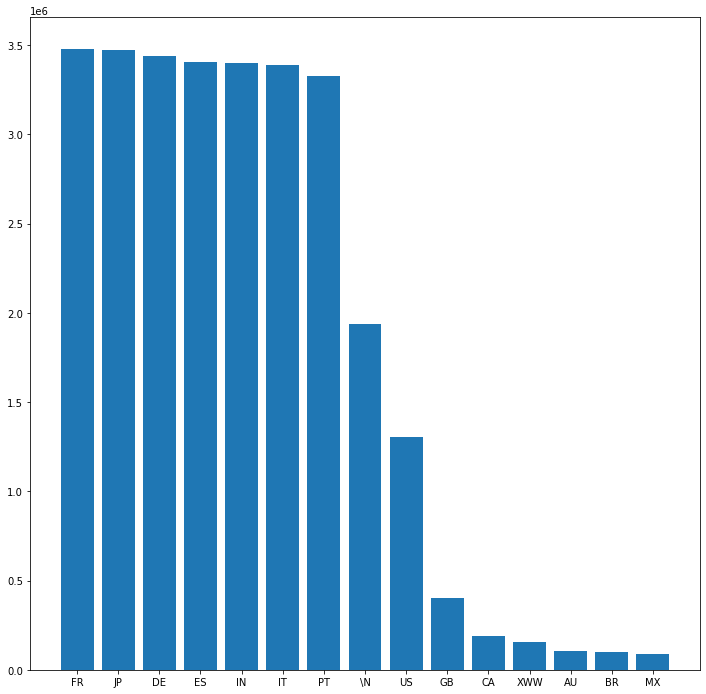

In [77]:
movie_By_Region2 = akas_df["region"].value_counts().reset_index().head(15)

fig, ax = plt.subplots(figsize = (12,12))

plt.bar(movie_By_Region2['index'], movie_By_Region2['region'])
plt.show()

# <span style="color:green">Quels sont les acteurs les plus présents ?</span> 

In [70]:
# Quels sont les acteurs les plus présents ?
# étape 1 : nettoyage de la data base
name_df2 = name_df.dropna(axis=0)
name_df3 = name_df2[name_df2['primaryProfession'] != '\\N']
name_df4 = name_df3[name_df3['birthYear'] != '\\N']
name_df5 = name_df4[name_df4['knownForTitles'] != '\\N']
name_df6 = name_df5[name_df5['primaryProfession'].str.contains('actor|actress')]
name_df6


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0031983,tt0050419,tt0053137"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0071877,tt0038355,tt0037382,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0056404,tt0057345,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0060827,tt0050976,tt0050986"
...,...,...,...,...,...,...
11314958,nm9992452,Yuki Katayama,1996,\N,actress,"tt8185442,tt7493810,tt6340500,tt14799066"
11315126,nm9992650,Pardeep Singh Sooch,1987,\N,actor,"tt10613832,tt4878326,tt11589366,tt4607112"
11315232,nm9992812,Daisy,1994,\N,actress,tt8281190
11315571,nm9993199,Denis Nurulin,1997,\N,actor,"tt14699208,tt13756156,tt12351166,tt8721954"


In [72]:
# Quels sont les acteurs les plus présents ?
# étape 2 : count how many times "tt" appears in the column knownForTitles and add result as a new column
# based on imdb website, Bradd Pitt is credited on 83 movies while in this database, he has only 4 titles in the column knownForTitles.

name_df6['numberOfKnownForTitles'] = name_df6['knownForTitles'].str.count("tt")
name_df6.sort_values(by=['numberOfKnownForTitles'], ascending=False).head(15)


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,numberOfKnownForTitles
447045,nm0472407,Dora Krsková,1978,\N,actress,"tt0356799,tt0117535,tt7174612,tt6368164,tt1024...",6
16733,nm0017292,Bill Alcorn,1920,\N,actor,"tt0050012,tt0036922,tt0037913,tt0037939,tt0045187",5
4143434,nm1585794,Stepán Krticka,1996,\N,"actor,writer","tt0401938,tt1720862,tt15134670,tt1890683,tt295...",5
106877,nm0112122,Lucius Brooks,1911,1999,"actor,soundtrack","tt0031122,tt0028978,tt0820851,tt1147443,tt0031406",5
1021814,nm10102449,Zachary Iziah Smith,1991,\N,"actor,composer,writer","tt10690610,tt10691474,tt10633130,tt15445360,tt...",5
3765636,nm1291804,Boguslaw Danielewski,1928,\N,actor,"tt0070946,tt0082976,tt0057196,tt0168935",4
3766442,nm1291900,Marianne Devriese,1979,\N,actress,"tt2569488,tt1783844,tt0800746,tt0955211",4
3766376,nm1291892,Eric Deskin,1964,\N,"actor,writer","tt0805669,tt1877893,tt0452046,tt0098844",4
3766314,nm1291886,Sandy Denny,1947,1978,"soundtrack,actress","tt0120613,tt0245407,tt0202559,tt0118926",4
3765829,nm1291827,Dawei Tong,1979,\N,"actor,producer","tt2278392,tt1326972,tt1410063,tt0425637",4


In [33]:
name_df6.loc[name_df6['primaryName'] == "Nikita"]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
28697,nm0029909,Nikita,1975,\N,actress,"tt0110214,tt0281098,tt8535182,tt0124819"
1045410,nm1012715,Nikita,1969,\N,actress,"tt0402502,tt2486856,tt5809076,tt0289360"
3244359,nm12372241,Nikita,2001,\N,actress,"tt13905778,tt14726182,tt14548106"
4107801,nm1546716,Nikita,1980,\N,actress,"tt2721492,tt8591668,tt2851308,tt14294686"
4149544,nm1592411,Nikita,1984,\N,actress,"tt1462625,tt0406569,tt0891462,tt6268790"
4186085,nm1640797,Nikita,1980,\N,actress,"tt1263040,tt1263026,tt0416137,tt0465501"
8098258,nm6061844,Nikita,1990,\N,actress,"tt6140626,tt13352842,tt4815378,tt14605424"


In [34]:
name_df6.loc[name_df6['primaryName'] == "Brad Pitt"]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
92,nm0000093,Brad Pitt,1963,\N,"actor,producer,soundtrack","tt2935510,tt0356910,tt0114746,tt1210166"


In [79]:
principals_df.loc[(principals_df['nconst'] == "nm0000093") & (principals_df['category'] == "actor")]

,tconst,ordering,nconst,category,job,characters
829922,tt0097136,3,nm0000093,actor,\N,"[""Dwight Ingalls""]"
844623,tt0098804,2,nm0000093,actor,\N,"[""Walker Lovejoy""]"
861832,tt0100797,3,nm0000093,actor,\N,"[""Billy Canton""]"
865963,tt0101268,2,nm0000093,actor,\N,"[""Joe Maloney""]"
889700,tt0104007,4,nm0000093,actor,\N,"[""Cox""]"
...,...,...,...,...,...,...
39331701,tt7076558,2,nm0000093,actor,\N,"[""Weatherman""]"
39456432,tt7122930,2,nm0000093,actor,\N,"[""Weatherman""]"
39478669,tt7131622,2,nm0000093,actor,\N,"[""Cliff Booth""]"
42305449,tt8205418,4,nm0000093,actor,\N,"[""Weatherman""]"


In [82]:
principals_df[principals_df['category'].str.contains('actor|actress')]
principals_df['nconst'].value_counts()




,tconst,ordering,nconst,category,job,characters
11,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]"
12,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]"
16,tt0000007,1,nm0179163,actor,\N,\N
17,tt0000007,2,nm0183947,actor,\N,\N
21,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]"
...,...,...,...,...,...,...
47219882,tt9916856,4,nm10538647,actress,\N,"[""Kathi""]"
47219887,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]"
47219888,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]"
47219889,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]"


In [86]:
name_df.loc[name_df['nconst'] == "nm10120013"]

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
1038763,nm10120013,Sameera Sherief,\N,\N,"actress,producer","tt8998500,tt8997494,tt8998380,tt8996230"


In [84]:
principals_df2 = principals_df[principals_df['category'].str.contains('actor|actress')]
principals_df2

,tconst,ordering,nconst,category,job,characters
11,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]"
12,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]"
16,tt0000007,1,nm0179163,actor,\N,\N
17,tt0000007,2,nm0183947,actor,\N,\N
21,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]"
...,...,...,...,...,...,...
47219882,tt9916856,4,nm10538647,actress,\N,"[""Kathi""]"
47219887,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]"
47219888,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]"
47219889,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]"


In [85]:
principals_df2['nconst'].value_counts()

nm10120013    9708
nm1426682     7834
nm0004471     7146
nm6427507     6213
nm0151534     5880
              ... 
nm12358057       1
nm12358050       1
nm12347124       1
nm12347125       1
nm10538647       1
Name: nconst, Length: 2181055, dtype: int64

In [88]:
principals_df.loc[principals_df['nconst'] == "nm0000093"]

,tconst,ordering,nconst,category,job,characters
829922,tt0097136,3,nm0000093,actor,\N,"[""Dwight Ingalls""]"
844623,tt0098804,2,nm0000093,actor,\N,"[""Walker Lovejoy""]"
861832,tt0100797,3,nm0000093,actor,\N,"[""Billy Canton""]"
865963,tt0101268,2,nm0000093,actor,\N,"[""Joe Maloney""]"
889700,tt0104007,4,nm0000093,actor,\N,"[""Cox""]"
...,...,...,...,...,...,...
43538374,tt8638066,10,nm0000093,self,\N,"[""Self""]"
45473138,tt9313702,2,nm0000093,actor,\N,"[""Weatherman""]"
47077568,tt9863946,7,nm0000093,archive_footage,\N,"[""Floyd (Dick's Roommate)""]"
47155078,tt9893218,3,nm0000093,producer,producer,\N
